In [1]:
import pickle
from sklearn import manifold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from typing import Tuple, List, Any, Dict

random.seed(42)

### Set data paths and label names

In [2]:

HYDROGEN = 1
CARBON = 6
NITROGEN = 7
OXYGEN = 8

atom_map = {
    HYDROGEN: "Hydrogen",
    CARBON: "Carbon",
    NITROGEN: "Nitrogen",
    OXYGEN: "Oxygen"
}

model_outputs = [
    pickle.load(open('./data/outputs_lumo_model.pkl', 'rb')),
    pickle.load(open('./data/outputs_TL_homo_lumo_model.pkl', 'rb')),
    pickle.load(open('./data/outputs_homo_lumo_model.pkl', 'rb'))
]

label_names = [
    "LUMO",
    "TF_LUMO",
    "HOMO_LUMO"
]

# model_outputs = [
#     pickle.load(open('./data/outputs_zpve_model.pkl', 'rb')),
#     pickle.load(open('./data/outputs_TL_Cv_zpve_model.pkl', 'rb')),
#     pickle.load(open('./data/outputs_Cv_zpve_model.pkl', 'rb'))
# ]

# label_names = [
#     "ZPVE",
#     "TL_ZPVE",
#     "CV_ZPVE"
# ]

MODEL_TYPE = "Lumo"
ATOM_TYPE = NITROGEN


In [3]:
DTU_RED = "#990000"
DTU_BLUE = "#2F3EEA"
DTU_GREEN = "#1FD082"
DTU_NAVY = "#030F4F"
DTU_YELLOW = "#F6D04D"
DTU_WHITE = "#FFFFFF"

color_map = {
    0: DTU_BLUE,
    1: DTU_RED,
    2: DTU_GREEN,
    3: DTU_NAVY
}

FILENAME = f"t_SNE_{MODEL_TYPE.lower()}_{atom_map[ATOM_TYPE].lower()}"

In [4]:
def get_embeddings(outputs: List[Dict[str, np.ndarray]], atom_number) -> np.ndarray:
    embeddings = []

    for d in outputs:
        dataset_embeddings = []
        for molecule in d:
            for idx in range(len(molecule["atom_numbers"])):
                if molecule["atom_numbers"][idx] == atom_number:
                    embd = molecule["embeddings"][idx]
                    dataset_embeddings.append(embd)

        embeddings.append(dataset_embeddings)

    return np.array(embeddings)

In [5]:
embd_tnse = get_embeddings(model_outputs, ATOM_TYPE)
print(embd_tnse.shape)

(3, 63438, 32)


In [6]:
num_models = embd_tnse.shape[0]
num_tnse_samples = embd_tnse.shape[1]

embd_tnse = embd_tnse.reshape(-1, 32)
print(embd_tnse.shape)

(190314, 32)


### Performing t-SNE on embeddings

In [7]:
tsne = manifold.TSNE(n_components=2, random_state=42, n_iter=1000, perplexity=50, learning_rate='auto')
tsne_res = tsne.fit_transform(embd_tnse)
tsne_x = tsne_res[:, 0]
tsne_y = tsne_res[:, 1]

print(tsne_x.shape)

In [ ]:
plot_data = []

for m in range(num_models):
    plot_data.append({
        "x": tsne_x[m*num_tnse_samples : (m + 1)*num_tnse_samples],
        "y": tsne_y[m*num_tnse_samples : (m + 1)*num_tnse_samples],
        "color": color_map[m],
        "label": label_names[m]
    })

print(plot_data[0]["label"])

ZPVE


### Extract samples

In [ ]:
NUM_SAMPLES = 8

# random.seed(61)

samples_idx = np.array(random.sample(range(num_tnse_samples), NUM_SAMPLES))
samples_x, samples_y, sample_colors, class_indicies = [], [], [], []

for m in range(num_models):
    c_idices = samples_idx + m*num_tnse_samples
    samples_x.append(tsne_x[c_idices])
    samples_y.append(tsne_y[c_idices])
    sample_colors = sample_colors + [color_map[m]] * NUM_SAMPLES
    class_indicies = class_indicies + list(samples_idx)

samples_x = np.array(samples_x).flatten()
samples_y = np.array(samples_y).flatten()


### Plotting

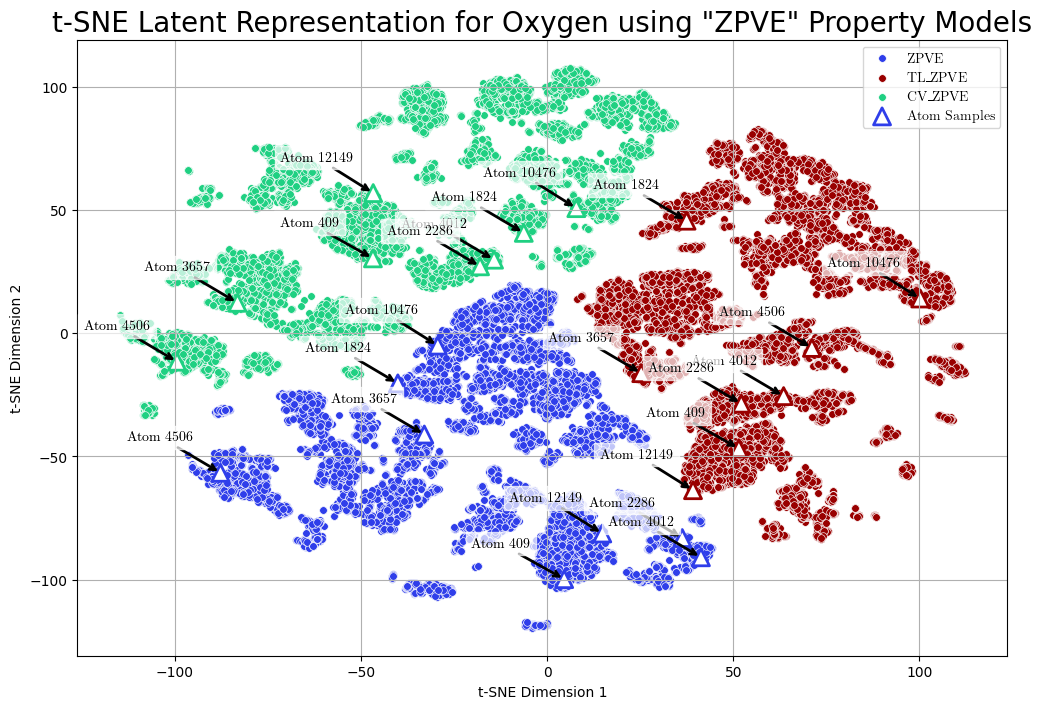

In [ ]:
# Create the plots directory if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')

plt.figure(figsize=(12, 8))
plt.grid(True)  # Add gridlines

for m in range(num_models):
    sns.scatterplot(
        x=plot_data[m]["x"], 
        y=plot_data[m]["y"], 
        color=plot_data[m]["color"], 
        label=plot_data[m]["label"],
        s=30
        )

sns.scatterplot(x=samples_x, 
                y=samples_y, 
                color=DTU_WHITE, 
                edgecolor=sample_colors, 
                linewidth=2, 
                label='Atom Samples', 
                s=150, 
                marker='^')
plt.rc('text', usetex=True)
plt.rc('font', family='serif') 
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.title(f"t-SNE Latent Representation for {atom_map[ATOM_TYPE]} using \"{MODEL_TYPE}\" Property Models", fontsize=20)


# Add arrows and sample annotations
OFFSET_X = -25
OFFSET_Y = 13
for i, (x, y) in enumerate(zip(samples_x, samples_y)):
    plt.text(
        x + OFFSET_X, 
        y + OFFSET_Y, 
        f'Atom {class_indicies[i]}',
        weight='bold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='white')
    )
    plt.annotate(
        f'Atom {class_indicies[i]}', 
        (x, y), 
        xytext=(x + OFFSET_X, y + OFFSET_Y), 
        arrowprops=dict(arrowstyle='->', linewidth=2), 
        zorder=2,
        weight='bold'
    )

# save the plot as a PDF
plt.savefig(f"./plots/{FILENAME}.pdf")
plt.show()